# *FARADAY ROTATION* | AC ANALYSIS
## Apr-1-2021 13:45

Here we perform the analysis of all the measurements

In [1]:
# Import the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as consts
from tqdm import tqdm
import os
from csvlib import *
from scipy.optimize import curve_fit
import matplotlib

# Display mpl in notebook format
%matplotlib inline

# Data Analysis

Here are the functions we used to analyse our data

In [2]:
# First we pick a data set using a folder name
directory = 'AC_VERDET_ROD'     # Directory of the data
angle_correction = 343.81
angle_c          = angle_correction/180*np.pi
pol_angle        = 3.896113 # degrees
pol_angle_rad    = pol_angle/180*np.pi

# Now define some parameters for the experiment
params = {
    'P_max'        : 1e-3,           # Laser source power in W
    'R_sensor'     : 1e+3,           # Sensor Resistance in Ω
    'K_sensor'     : 0.6,            # Sensor Responsivity in A/W
    'G_preamp'     : 1,              # Preamplifier Gain
    'G_filter'     : 1,              # Low Pass filter Gain
    'G_lock_in'    : 1,              # Lock in Gain
    'K_lock_in'    : 1/2,            # Lock in Constant
    'G_lp_amp'     : 1,              # Lock in, low pass amplifier gain
    'K_solenoid'   : 0.011,          # Solenoid constant in T/A
    'Length'       : 1e-2,           # Material length in the solenoid in m
    'Sigma_L'      : 1e-3,           # Uncertainty in Length
}

# print the setup file for this directory
def print_setup(directory=directory):
    file = open(directory+'/Setup.txt')
    lines = file.readlines()
    file.close
    
    for line in lines:
        print(line,end='')

# Returns a data frame for the measurements of that particular angle
def get_angle(angle,directory=directory):
    angle = int(angle)
    data = pd.read_csv(directory+'/Angle-%d.csv'%angle)

    return data.to_numpy().T

# Get the raw data for voltage and amplitude
def get_voltage_vs_amplitude(directory=directory):
    data = pd.read_csv(directory+'/Voltage-Amplitude.csv'%angle)
    return data.to_numpy().T

# Returns average and standard deviation
def get_stats(data):
    return np.mean(data), np.std(data)

# Returns a calculated data set with mean and stds for a set of angles
def voltage_vs_angle(angles=np.linspace(0,360,360,dtype=int),directory=directory,channel=5):
    V = []
    V_std = []
    
    for angle in tqdm(angles):
        data = get_angle(angle,directory=directory)
        mean,std = get_stats(data[channel])

        V.append(mean)
        V_std.append(std)

    return np.array(V),np.array(V_std),angles

# get the raw data for the current among a list of angles
def get_current_ac(angles=np.linspace(0,360,360,dtype=int),directory=directory,channel=1):
    time  = np.array(get_angle(0)[0])
    I     = np.zeros(time.shape)
    I_std = np.zeros(time.shape)
    
    for angle in tqdm(angles):
        data = get_angle(angle,directory=directory)
        I += data[channel]
    
    I = np.array(I)/len(angles)
    
    for angle in tqdm(angles):
        data = get_angle(angle,directory=directory)
        I_std += (np.array(data[channel]) - I)**2
    
    I_std /= len(angles)
    
    return I, I_std**0.5, time



# obtain the phase difference and verdet constant due to rotation from the signal amplitude plot
def calc_verdet_ac(voltage,voltage_std,current,current_std,average=0.95,params=params):
    # First calculate the phase shift from the amplitude of the signal
    V_max = np.mean([abs(i) for i in voltage if abs(i)/max(voltage) >= average])
    print('V_Max:\t',V_max)
    
    Gain  = params['G_preamp']*params['G_filter']*params['G_lp_amp']*params['G_lock_in']
    K     = params['K_sensor']
    R     = params['R_sensor']
    K_loc = params['K_lock_in']
    P     = params['P_max']
    cor   = params['Correction']
    
    # This is the phase shift
    f = 2 * V_max / (Gain * K * K_loc * R * P)
    Delta_phi = np.arccos(f**0.5)*180/np.pi - cor - 53
    Delta_phi = f
    
    # To get the phase uncertainty 
    sigma_V = [voltage_std[i]**2 for i in range(len(voltage)) if abs(voltage[i])/max(voltage) >= average]
    sigma_V = (np.sum(sigma_V)/len(sigma_V))**0.5
    sigma_phi = ((abs(f)/V_max * sigma_V)**2)**0.5
    
    
    # Now to get the Verdet constant
    I_max = np.mean([abs(i) for i in current if abs(i)/max(current) >= average])
    
    B = params['K_solenoid'] * I_max
    l = params['Length']
    
    
    Verdet = Delta_phi / (B * l)
    
    # To get the verdet uncertainty
    sigma_I = [current_std[i]**2 for i in range(len(current)) if abs(current[i])/max(current) >= average]
    sigma_I = (np.sum(sigma_I)/len(sigma_I))**0.5
    sigma_I = abs(sigma_I * Verdet/I_max)
    sigma_L = abs(params['Sigma_L'] * Verdet/l)
    
    print(sigma_I)
    
    sigma_Verdet = (sigma_I**2 + sigma_L**2 + (sigma_phi/(B*l))**2 )**0.5
    
    # Return the two values
    return Verdet, sigma_Verdet, Delta_phi, sigma_phi


def calc_verdet_ac_given(V_max,V_std,current,current_std,average=0.95,params=params):
    # First calculate the phase shift from the amplitude of the signal
    print('V_Max:\t',V_max)
    
    Gain  = params['G_preamp']*params['G_filter']*params['G_lp_amp']*params['G_lock_in']
    K     = params['K_sensor']
    R     = params['R_sensor']
    K_loc = params['K_lock_in']
    P     = params['P_max']
    cor   = params['Correction']
    
    # This is the phase shift
    f = 2 * V_max / (Gain * K * K_loc * R * P)
    Delta_phi = np.arccos(f**0.5)*180/np.pi - cor - 53
    Delta_phi = f
    
    # To get the phase uncertainty 
    sigma_V = V_std
    sigma_phi = ((abs(f)/V_max * sigma_V)**2)**0.5
    
    
    # Now to get the Verdet constant
    I_max = np.mean([abs(i) for i in current if abs(i)/max(current) >= average])
    
    B = params['K_solenoid'] * I_max
    l = params['Length']
    
    
    Verdet = Delta_phi / (B * l)
    
    # To get the verdet uncertainty
    sigma_I = [current_std[i]**2 for i in range(len(current)) if abs(current[i])/max(current) >= average]
    sigma_I = (np.sum(sigma_I)/len(sigma_I))**0.5
    sigma_I = abs(sigma_I * Verdet/I_max)
    sigma_L = abs(params['Sigma_L'] * Verdet/l)
    
    print(sigma_I)
    
    sigma_Verdet = (sigma_I**2 + sigma_L**2 + (sigma_phi/(B*l))**2 )**0.5
    
    # Return the two values
    return Verdet, sigma_Verdet, Delta_phi, sigma_phi


# Plot a voltage VS amplitude graph
def plot_VA(angles=np.linspace(0,360,360,dtype=int),V=None,V_std=None,directory=directory,channel=5,\
            title='Lock-in Output VS Angle',average=0.97):

    if type(V) == type(None) or type(V_std) == type(None):
        V,V_std,_ = voltage_vs_angle(directory=directory,channel=channel)

    # Create the figure
    fig = plt.figure(figsize=(15,5),dpi=300)
    ax = fig.add_subplot(111)
    
    # Plot
    ax.errorbar(angles/180,V,yerr=V_std,color='deepskyblue',fmt='.',ms=2,label='Raw Data')
    
    # Make the figure look pretty
    ax.set_xlim(min(angles)/180, max(angles)/180)
    ax.set_ylim(min(V)*1.1,max(V)*1.1)
    grid_x_major = np.arange(min(angles)/180, max(angles)/180, 0.25)
    grid_x_minor = np.arange(min(angles)/180, max(angles)/180, 0.25/5)

    ax.set_title(title)
    ax.set_xlabel(r'Polariser Angle $\theta$ [rad]')
    ax.set_ylabel(r'Lock-in output V [V]')
    
    ax.set_xticks(grid_x_major)
    ax.set_xticks(grid_x_minor,minor=True)
    ax.xaxis.grid(True, which='both')
    ax.grid(which='minor', alpha=0.4, linestyle='--')
    ax.tick_params(axis="both",which="both", direction="in")
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))
    
    ax.fill_between(angles/180, 2*min(V), 2*max(V), where=(abs(V) > max(V)*average), color='deepskyblue',alpha=0.5,\
                    label='Maximum Oscillation Areas')

    ax.legend(frameon = False)
    
    return fig,ax

# Plot the lock in at a particular angle
def plot_lock_in(angle,directory=directory,channel=3):
    data    = get_angle(angle,directory=directory)
    time    = data[2*(channel-1)]
    lock_in = data[2*(channel-1)+1]

    fig = plt.figure(figsize=(13,5))
    ax = fig.add_subplot(111)
    ax.plot(time,lock_in,color='mediumseagreen')

    return fig,ax

# AC Verdet analyisis
This will perform the analysis for the verdet constant of the ROD done using lock in amplification

100%|██████████| 360/360 [00:00<00:00, 382.73it/s]


Phase aligned without polariser
LENGTH:     10.175 ± 0.005 cm

Preamp
-------------------
AC Coupling
Grounded
GAIN:   10


Lock-In
-------------------
AC-Coupling
Splitter to Oscilloscope
REF from Phase shifter
LOCK-IN Mode
GAIN:   20


Oscillator
-------------------
Amplitude:  3V
Frequency:  36.4 Hz
Sine
No attenuation
OUTPUT to PHASE SHIFTER and AUDIO AMPLIFIER

Phase shifter
-------------------
Phase-Course:   180
Phase-Fine:     75


Low Pass Filter Amp
-------------------
Time Constant:  0.03 s
GAIN:           20
X:              12 dB/oct
Offset:         -0.2 V

Audio AMPLIFIER
-------------------
DC Input
Current:        480 mA rmsV_Max:	 4.271600938990985
0.7770446521169123
V:	 24.055327918399673 0.9275073203711743
φ:	 0.01779833724579577 0.0003746013296793439


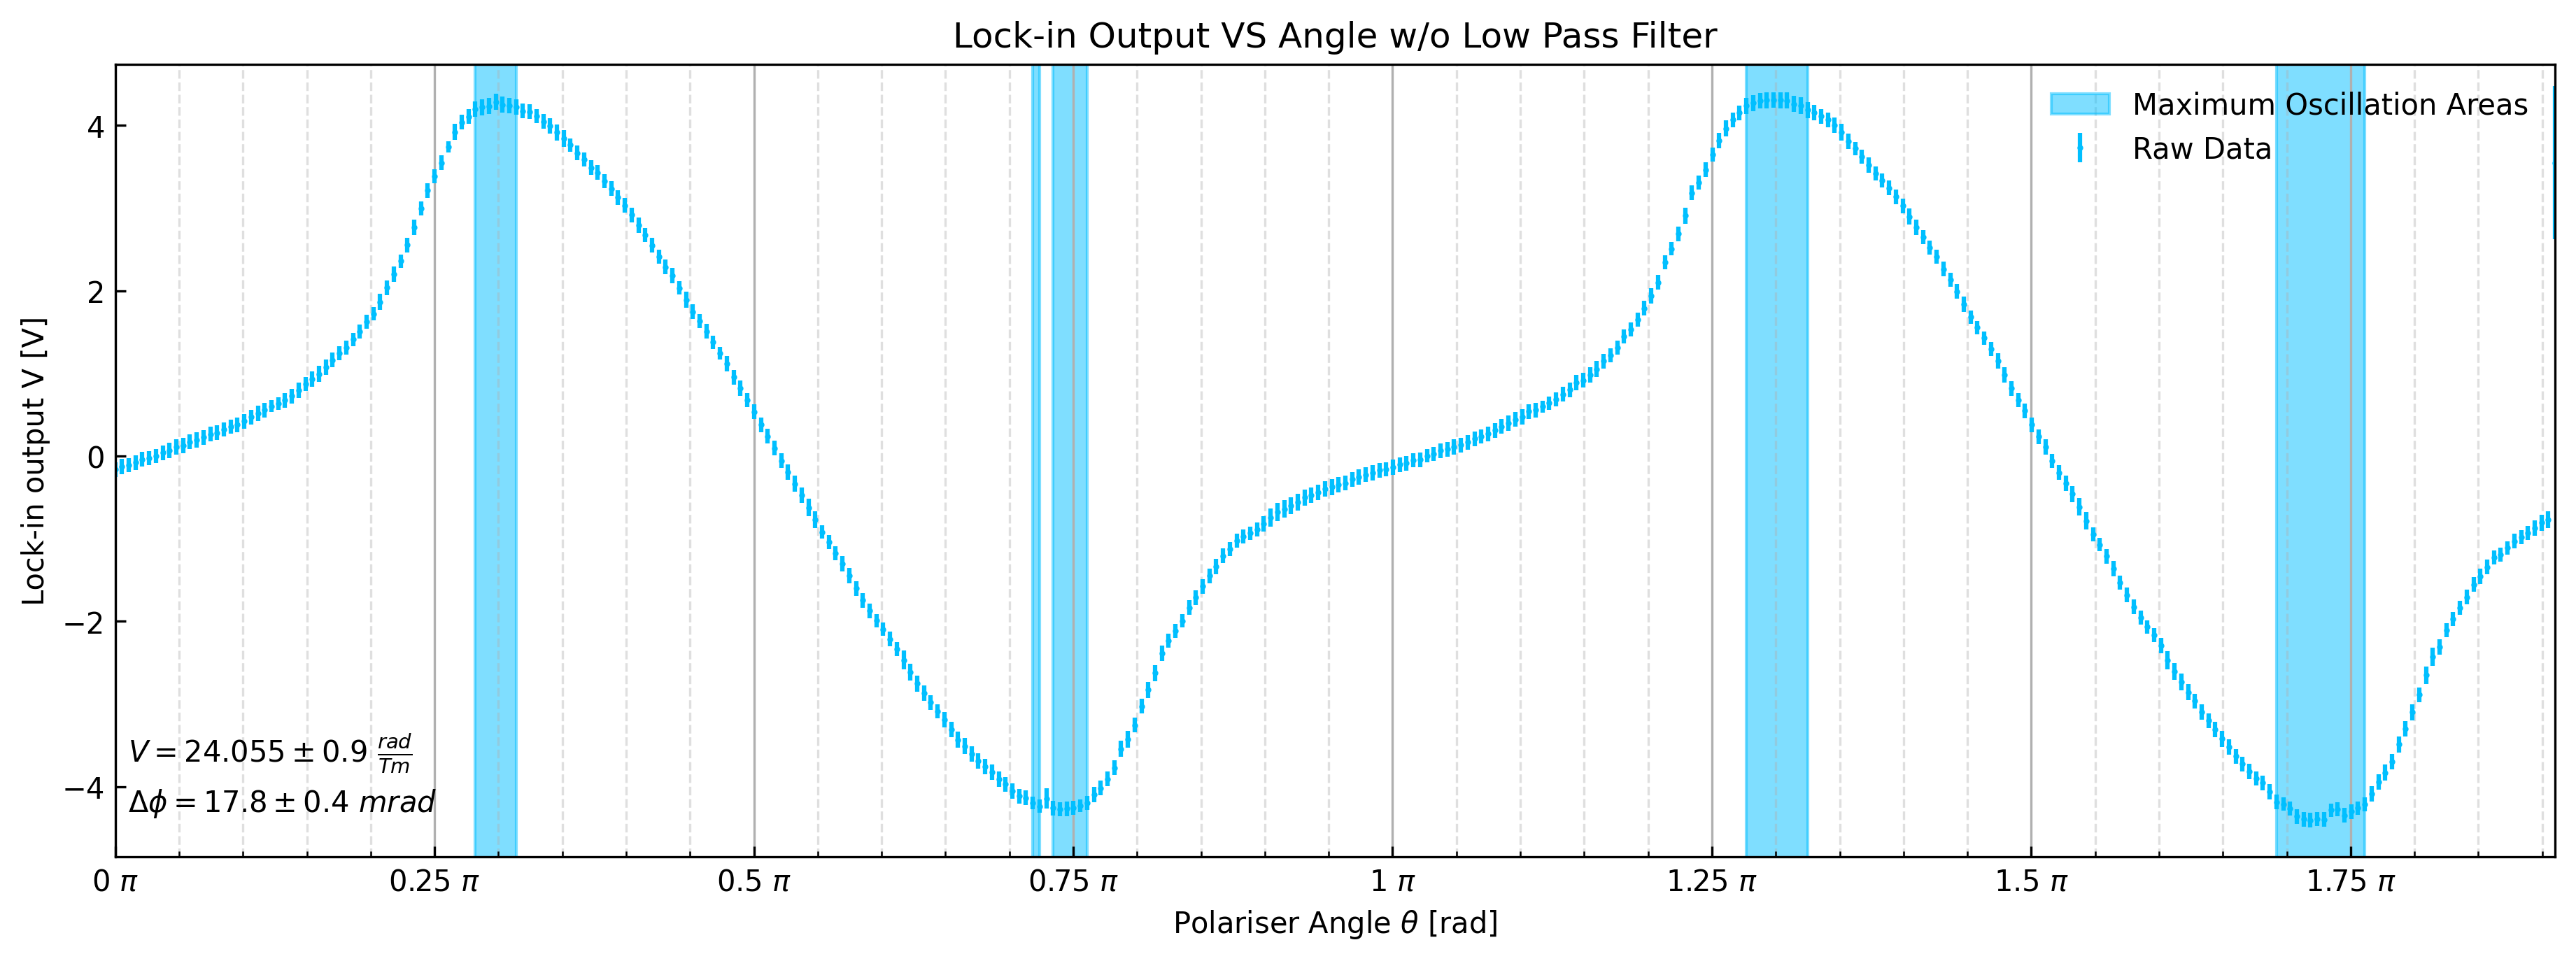

In [3]:
# Set the directory with the measurements
directory = 'AC_VERDET_ROD'

# Set the parameters of the experiment
params = {
    'P_max'        : 2e-3,           # Laser source power in W
    'R_sensor'     : 1e+3,           # Sensor Resistance in Ω
    'K_sensor'     : 0.6,            # Sensor Responsivity in A/W
    'G_preamp'     : 10,             # Preamplifier Gain
    'G_filter'     : 1,              # Low Pass filter Gain
    'G_lock_in'    : 20,             # Lock in Gain
    'K_lock_in'    : 1/10,           # Lock in Constant
    'G_lp_amp'     : 20,             # Lock in, low pass amplifier gain
    'K_solenoid'   : 0.011,          # Solenoid constant in T/A
    'Length'       : 10.175e-2,      # Material length in the solenoid in m
    'Sigma_L'      : 0.005e-2,       # Uncertainty in Length in m
    'Correction'   : pol_angle       # Correction angle to account for the difference of the polarizers
}
angles = np.linspace(0,360,360,dtype=int)
average = 0.97

# Get the relevant data
voltage, voltage_std, angles = voltage_vs_angle(directory=directory)
angles = np.linspace(0,angle_correction,360)
voltage -= np.mean(voltage)
current, current_std, time = get_current_ac(angles=angles,directory=directory)

print_setup(directory)          # Print the setup for the particular experiment

# Plot the voltage VS angle curve
fig,ax = plot_VA(angles=angles,V=voltage,V_std=voltage_std,directory=directory,average=average,\
                 title='Lock-in Output VS Angle w/o Low Pass Filter')

# Calculate Verdet constant
V,V_std, Phi,Phi_std = calc_verdet_ac(voltage,voltage_std,current,current_std,average=average,params=params)

ax.text(0.01, -3.7, r'$V=%.3f \pm %.1f\ \frac{rad}{Tm}$'%(V,V_std))
ax.text(0.01, -4.3, r'$\Delta\phi=%.1f \pm %.1f\ mrad}$'%(Phi*1e3,Phi_std*1e3))

print("V:\t",V,V_std) # 21.0 rad/Tm
print("φ:\t",Phi,Phi_std)

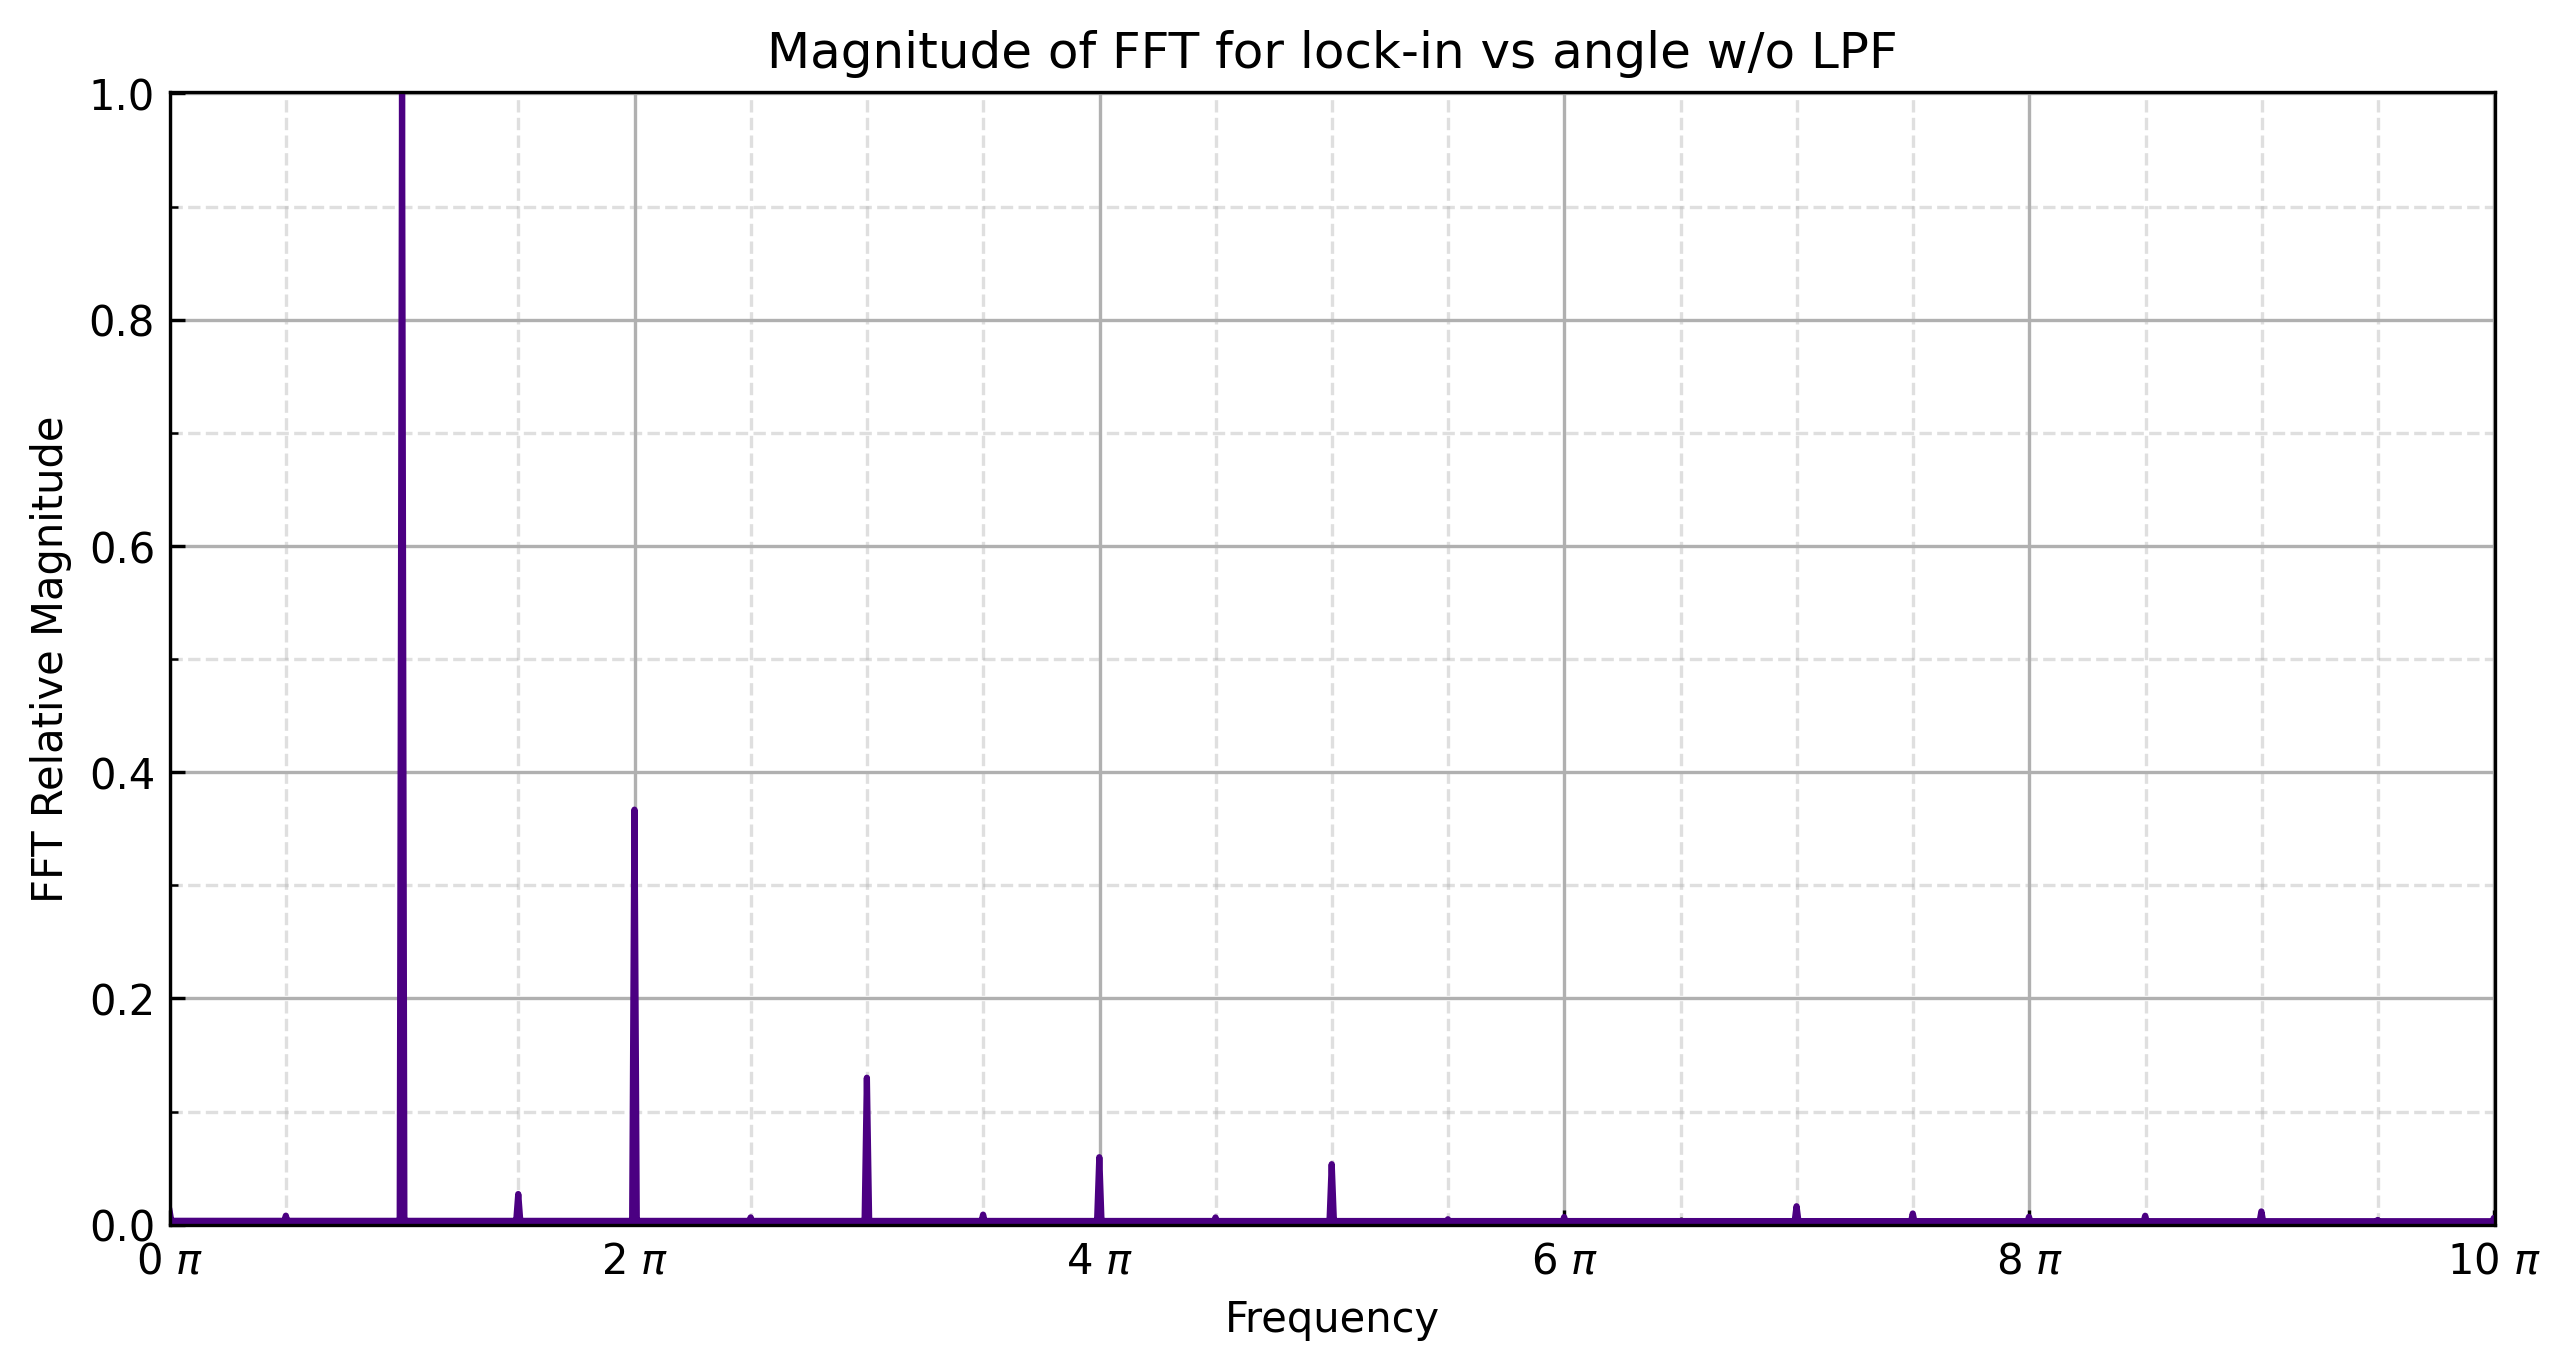

In [47]:
# Get the fourier transform of the signal
import numpy.fft as fft

N=50
Npts = int(360/angle_correction * 360)
fit_voltage = np.append(voltage,np.linspace(voltage[-2],voltage[0],Npts-360))
fit_voltage = np.tile(fit_voltage,N)
fit_angles = np.tile(np.linspace(0,360,Npts),N)

F = fft.fft(fit_voltage)
Freq = fft.fftfreq(len(fit_voltage),((angles[2]-angles[1])/180*np.pi))


# Plot the transform
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_subplot(111)

ax.plot(Freq*np.pi,abs(F)/max(abs(F)),c='indigo')

# Make the figure look pretty
min_x = 0
max_x = 10+0.001
min_y = 0
max_y = 1+0.001

ax.set_title('Magnitude of FFT for lock-in vs angle w/o LPF')
ax.set_xlabel(r'Frequency')
ax.set_ylabel(r'FFT Relative Magnitude')

ax.set_xlim(min_x, max_x)
grid_x_major = np.arange(min_x, max_x, 2)
grid_x_minor = np.arange(min_x, max_x, 2/4)

ax.set_xticks(grid_x_major)
ax.set_xticks(grid_x_minor,minor=True)
ax.xaxis.grid(True, which='both')

ax.set_ylim(min_y,max_y)
grid_y_major = np.arange(min_y, max_y, 0.2)
grid_y_minor = np.arange(min_y, max_y, 0.1)

ax.set_yticks(grid_y_major)
ax.set_yticks(grid_y_minor,minor=True)
ax.yaxis.grid(True, which='both')


ax.grid(which='minor', alpha=0.4, linestyle='--')
ax.tick_params(axis="both",which="both", direction="in")

ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))

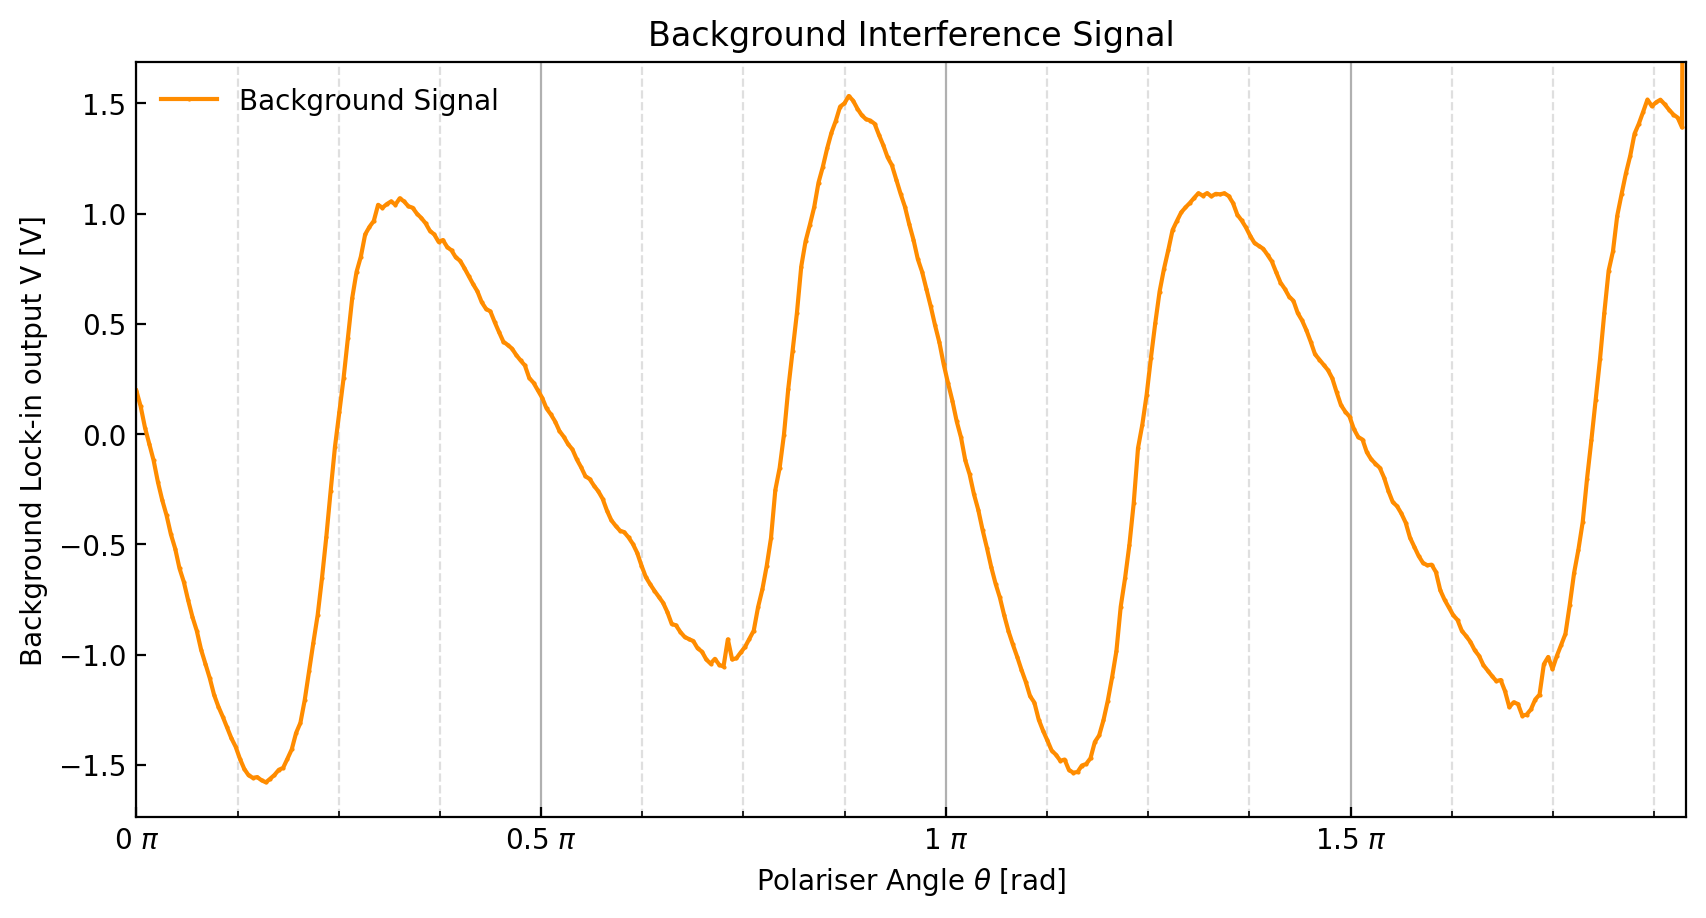

In [78]:
# Obtain the inverse fourier transform
sigma = 0.1
freq = 1/np.pi
G  = (np.exp(-(Freq-freq)**2/sigma**2)+np.exp(-(Freq+freq)**2/sigma**2))
G  = 1 - G/max(G)
FF = fft.ifft(F*G).real[:360]
angles = fit_angles[:360]/180*np.pi

# Plot it
fig = plt.figure(figsize = (10,5),dpi=200)
ax = fig.add_subplot(111)

ax.plot(angles/np.pi,FF,marker='.',ms=1,c='darkorange',label='Background Signal')

# Make the figure look pretty
ax.set_xlim(min(angles)/np.pi, max(angles)/np.pi)
ax.set_ylim(min(FF)*1.1,max(FF[0:-1])*1.1)
grid_x_major = np.arange(min(angles)/np.pi, max(angles)/np.pi, 1/2)
grid_x_minor = np.arange(min(angles)/np.pi, max(angles)/np.pi, 1/8)

ax.set_title('Background Interference Signal')
ax.set_xlabel(r'Polariser Angle $\theta$ [rad]')
ax.set_ylabel(r'Background Lock-in output V [V]')

ax.set_xticks(grid_x_major)
ax.set_xticks(grid_x_minor,minor=True)
ax.xaxis.grid(True, which='both')
ax.grid(which='minor', alpha=0.4, linestyle='--')
ax.tick_params(axis="both",which="both", direction="in")
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))


ax.legend(frameon = False)

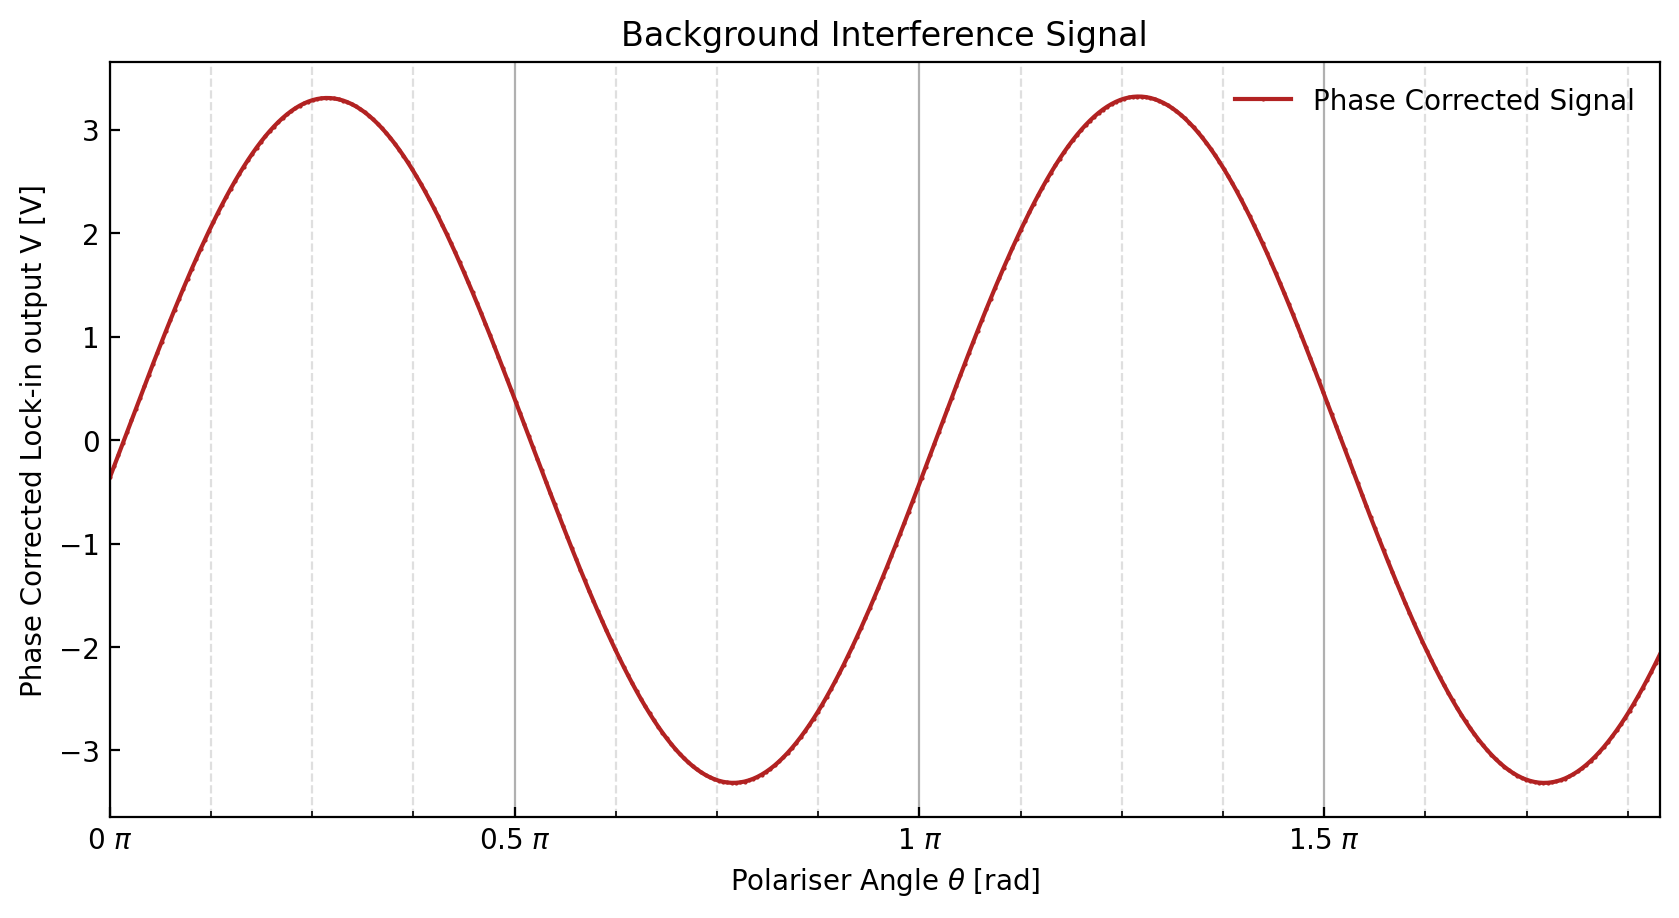

In [79]:
# To test if our iFFT was sucessful we can subtract the background from the voltage

# Plot it
fig = plt.figure(figsize = (10,5),dpi=200)
ax = fig.add_subplot(111)

ax.plot(angles/np.pi,voltage - FF,marker='.',ms=1,c='firebrick',label='Phase Corrected Signal')

# Make the figure look pretty
ax.set_xlim(min(angles)/np.pi, max(angles)/np.pi)
ax.set_ylim(min(voltage - FF)*1.1,max(voltage - FF)*1.1)
grid_x_major = np.arange(min(angles)/np.pi, max(angles)/np.pi, 1/2)
grid_x_minor = np.arange(min(angles)/np.pi, max(angles)/np.pi, 1/8)

ax.set_title('Background Interference Signal')
ax.set_xlabel(r'Polariser Angle $\theta$ [rad]')
ax.set_ylabel(r'Phase Corrected Lock-in output V [V]')

ax.set_xticks(grid_x_major)
ax.set_xticks(grid_x_minor,minor=True)
ax.xaxis.grid(True, which='both')
ax.grid(which='minor', alpha=0.4, linestyle='--')
ax.tick_params(axis="both",which="both", direction="in")
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))


ax.legend(frameon = False)

100%|██████████| 360/360 [00:01<00:00, 351.70it/s]


Phase aligned without polariser
Low pass filter added
LENGTH:     10.175 cm

Channel 1: Current
Channel 2: Preamp
Channel 3: Lock in OUTPUT
Channel 4: Lock in INPUT

Preamp
-------------------
AC Coupling
Grounded
GAIN:   10

Low Pass Filter
-------------------
Q:          2 (GAIN 10)
f_course:   100-300
f_cutoff:   150

Lock-In
-------------------
AC-Coupling
Splitter to Oscilloscope
REF from Phase shifter
LOCK-IN Mode
GAIN:   20


Oscillator
-------------------
Amplitude:  3V
Frequency:  36.4 Hz
Sine
No attenuation
OUTPUT to PHASE SHIFTER and AUDIO AMPLIFIER

Phase shifter
-------------------
Phase-Course:   0
Phase-Fine:     45


Low Pass Filter Amp
-------------------
Time Constant:  0.03 s
GAIN:           20
X:              12 dB/oct
Offset:         -0.15 V

Audio AMPLIFIER
-------------------
DC Input
Current:        493.9 ± 0.800 mA rms[ 2.21506059  2.00000407 -0.12428258  1.10217863]
V_Max:	 2.227555675860565
0.7786085934064855
V:	 24.06366348400382 0.868545545098085
φ:	 0.0185

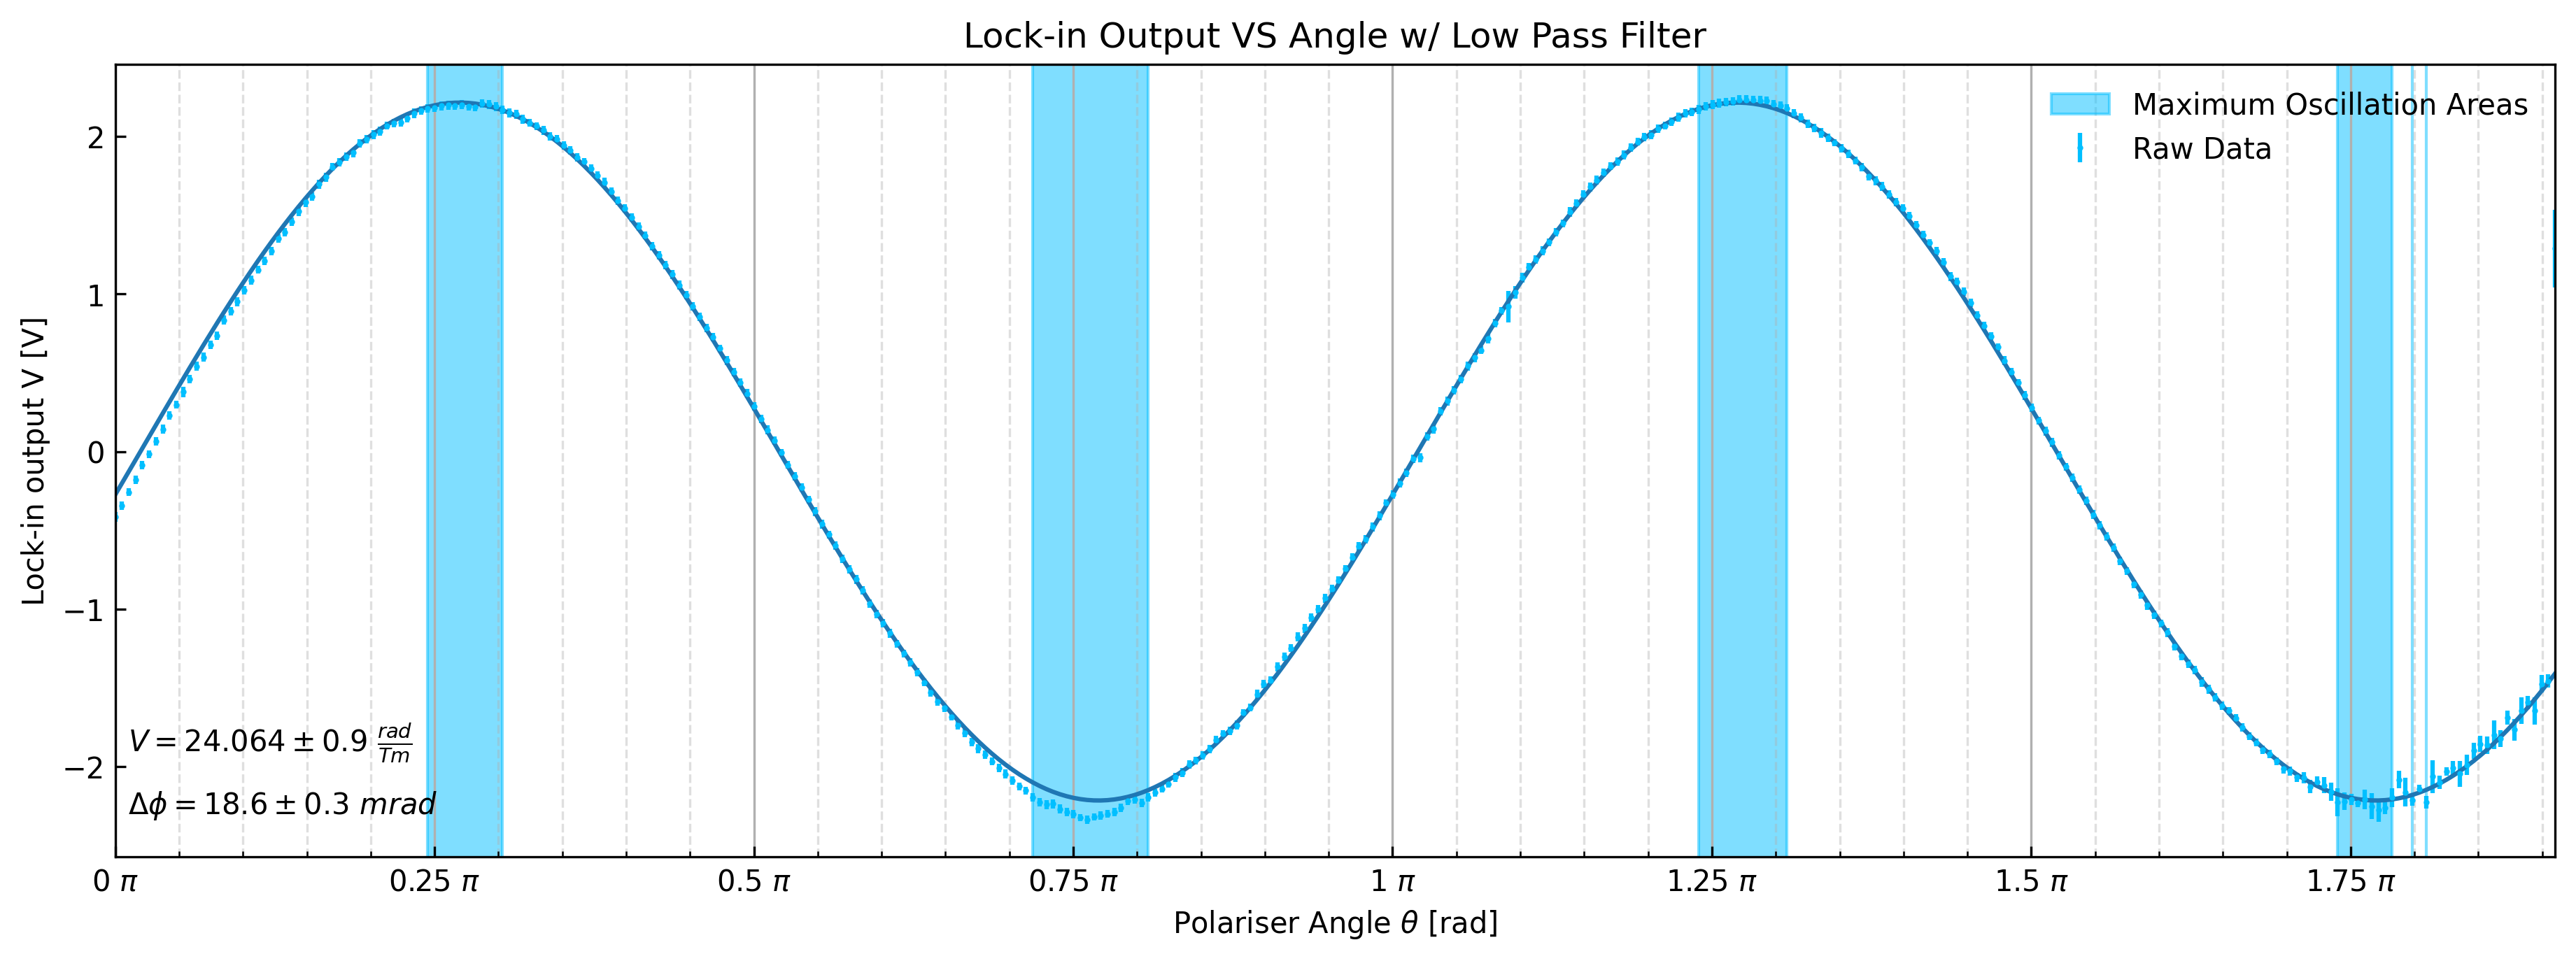

In [180]:
# Set the directory with the measurements
directory = 'AC_VERDET_ROD_LPF'

# Set the parameters of the experiment
params = {
    'P_max'        : 0.5e-3,        # Laser source power in W
    'R_sensor'     : 1e+3,           # Sensor Resistance in Ω
    'K_sensor'     : 0.6,            # Sensor Responsivity in A/W
    'G_preamp'     : 10,             # Preamplifier Gain
    'G_filter'     : 2,              # Low Pass filter Gain
    'G_lock_in'    : 20,             # Lock in Gain
    'K_lock_in'    : 1/10,           # Lock in Constant
    'G_lp_amp'     : 20,             # Lock in, low pass amplifier gain
    'K_solenoid'   : 0.011,          # Solenoid constant in T/A
    'Length'       : 10.175e-2,      # Material length in the solenoid in m
    'Sigma_L'      : 0.005e-2,       # Uncertainty in Length in m
    'Correction'   : pol_angle       # Correction angle to account for the difference of the polarizers
}
angles = np.linspace(0,360,360,dtype=int)
avg = 0.97

# Get the relevant data
voltage, voltage_std, angles = voltage_vs_angle(directory=directory)
angles = np.linspace(0,angle_correction,360)
# voltage -= np.mean(voltage[int(0*angle_correction/360):int(180*angle_correction/360)])
current, current_std, time = get_current_ac(angles=angles,directory=directory)

print_setup(directory)          # Print the setup for the particular experiment

# Fit the data
N = 50
fit_angles = np.zeros(len(angles)*N)
for n in range(N):
    for i in range(len(angles)):
        fit_angles[n*len(angles)+i] = angles[i]/180*np.pi + 2*np.pi*n

fit_voltage = np.tile(voltage,N)

fit = lambda theta, a,b,c,d: a*np.sin(b*theta + c) + d

pars, pcov = curve_fit(fit,fit_angles,fit_voltage,p0=[2,2,-pol_angle_rad,0],\
                      )#bounds=([0,0.5,-0.3,0],[4.2,5,0.3,4]))

errors = [(pcov[i][i])**0.5 for i in range(len(pars))]
print(pars)
voltage-=pars[-1]

# Plot the voltage VS angle curve
fig,ax = plot_VA(angles=angles,V=voltage,V_std=voltage_std,directory=directory,average=avg,\
                 title='Lock-in Output VS Angle w/ Low Pass Filter')

ax.plot(angles/180, fit(angles/180*np.pi,*pars)-pars[-1])

# Calculate Verdet constant
V,V_std, Phi,Phi_std = calc_verdet_ac(voltage,voltage_std,current,current_std,average=avg,params=params)

ax.text(0.01, -1.9, r'$V=%.3f \pm %.1f\ \frac{rad}{Tm}$'%(V,V_std))
ax.text(0.01, -2.3, r'$\Delta\phi=%.1f \pm %.1f\ mrad}$'%(Phi*1e3,Phi_std*1e3))

print("V:\t",V,V_std) # 21.0 rad/Tm
print("φ:\t",Phi,Phi_std)

100%|██████████| 360/360 [00:01<00:00, 336.27it/s]


Phase aligned without polariser
LENGTH:     21.2 (21.7 for the glass rod)

Preamp
-------------------
AC Coupling
Grounded
GAIN:   10


Lock-In
-------------------
AC-Coupling
Splitter to Oscilloscope
REF from Phase shifter
LOCK-IN Mode
GAIN:   20


Oscillator
-------------------
Amplitude:  3V
Frequency:  36.4 Hz
Sine
No attenuation
OUTPUT to PHASE SHIFTER and AUDIO AMPLIFIER

Phase shifter
-------------------
Phase-Course:   180
Phase-Fine:     76


Low Pass Filter Amp
-------------------
Time Constant:  0.03 s
GAIN:           50
X:              12 dB/oct
Offset:         -0.27 V

Audio AMPLIFIER
-------------------
DC Input
Current:        683 mA rmsV_Max:	 2.6002442625706514
0.04589758307912415
V:	 1.9326345445300683 0.08163715257865148
φ:	 0.004333740437617753 0.00015104626981775958


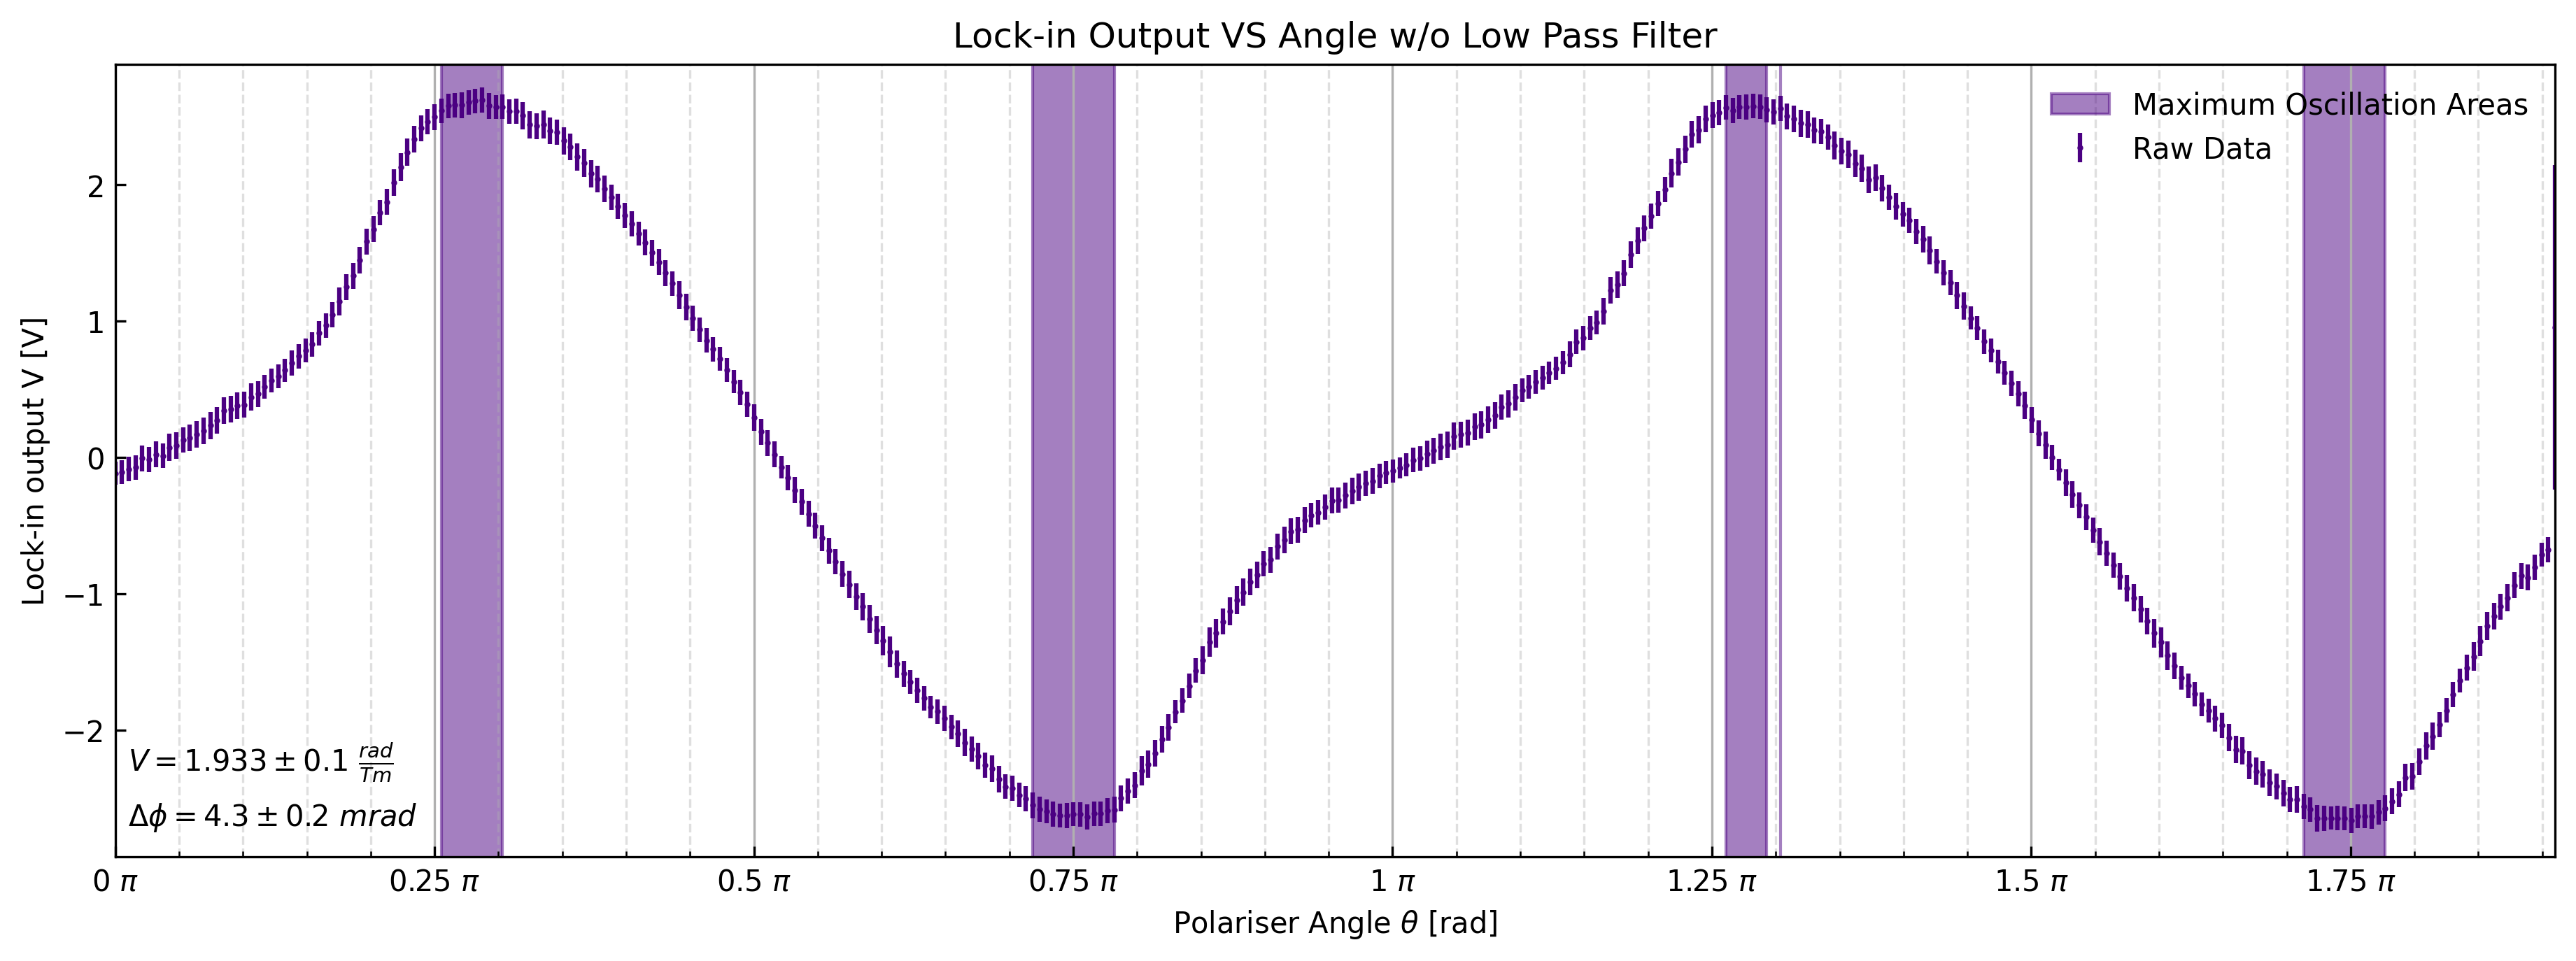

In [171]:
# Set the directory with the measurements
directory = 'AC_VERDET_WATER'

# Set the parameters of the experiment
params = {
    'P_max'        : 2e-3,           # Laser source power in W
    'R_sensor'     : 1e+3,           # Sensor Resistance in Ω
    'K_sensor'     : 0.6,            # Sensor Responsivity in A/W
    'G_preamp'     : 10,             # Preamplifier Gain
    'G_filter'     : 1,              # Low Pass filter Gain
    'G_lock_in'    : 20,             # Lock in Gain
    'K_lock_in'    : 1/10,           # Lock in Constant
    'G_lp_amp'     : 50,             # Lock in, low pass amplifier gain
    'K_solenoid'   : 0.011,          # Solenoid constant in T/A
    'Length'       : 21.2e-2,        # Material length in the solenoid in m
    'Sigma_L'      : 0.05e-2,        # Uncertainty in Length in m
    'Correction'   : pol_angle       # Correction angle to account for the difference of the polarizers
}
angles = np.linspace(0,360,360,dtype=int)
average = 0.97

# Get the relevant data
voltage, voltage_std, angles = voltage_vs_angle(directory=directory)
angles = np.linspace(0,angle_correction,360)
voltage -= np.mean(voltage)
current, current_std, time = get_current_ac(angles=angles,directory=directory)

print_setup(directory)          # Print the setup for the particular experiment

# Plot the voltage VS angle curve
fig,ax = plot_VA(angles=angles,V=voltage,V_std=voltage_std,directory=directory,average=average,\
                 title='Lock-in Output VS Angle w/o Low Pass Filter')

# Calculate Verdet constant
V,V_std, Phi,Phi_std = calc_verdet_ac(voltage,voltage_std,current,current_std,average=average,params=params)

ax.text(0.01, -2.3, r'$V=%.3f \pm %.1f\ \frac{rad}{Tm}$'%(V,V_std))
ax.text(0.01, -2.7, r'$\Delta\phi=%.1f \pm %.1f\ mrad}$'%(Phi*1e3,Phi_std*1e3))

print("V:\t",V,V_std) # 21.0 rad/Tm
print("φ:\t",Phi,Phi_std)

100%|██████████| 360/360 [00:01<00:00, 333.54it/s]


Phase aligned without polariser
Low pass filter added
LENGTH:     21.2 (21.7 for the glass rod)

Channel 1: Current
Channel 2: Preamp
Channel 3: Lock in OUTPUT
Channel 4: Lock in INPUT

Preamp
-------------------
AC Coupling
Grounded
GAIN:   10

Low Pass Filter
-------------------
Q:          2 (GAIN 10)
f_course:   100-300
f_cutoff:   150

Lock-In
-------------------
AC-Coupling
Splitter to Oscilloscope
REF from Phase shifter
LOCK-IN Mode
GAIN:   20


Oscillator
-------------------
Amplitude:  3V
Frequency:  36.4 Hz
Sine
No attenuation
OUTPUT to PHASE SHIFTER and AUDIO AMPLIFIER

Phase shifter
-------------------
Phase-Course:   0
Phase-Fine:     45


Low Pass Filter Amp
-------------------
Time Constant:  0.03 s
GAIN:           50
X:              12 dB/oct
Offset:         -0.37 V

Audio AMPLIFIER
-------------------
DC Input
Current:        684.0 ± 0.8 mA rms[ 0.63396939  2.00000553 -0.14015023  0.0194678 ]
V_Max:	 0.6339693945376736
0.04589626843665639
V:	 1.908737759849664 0.234639

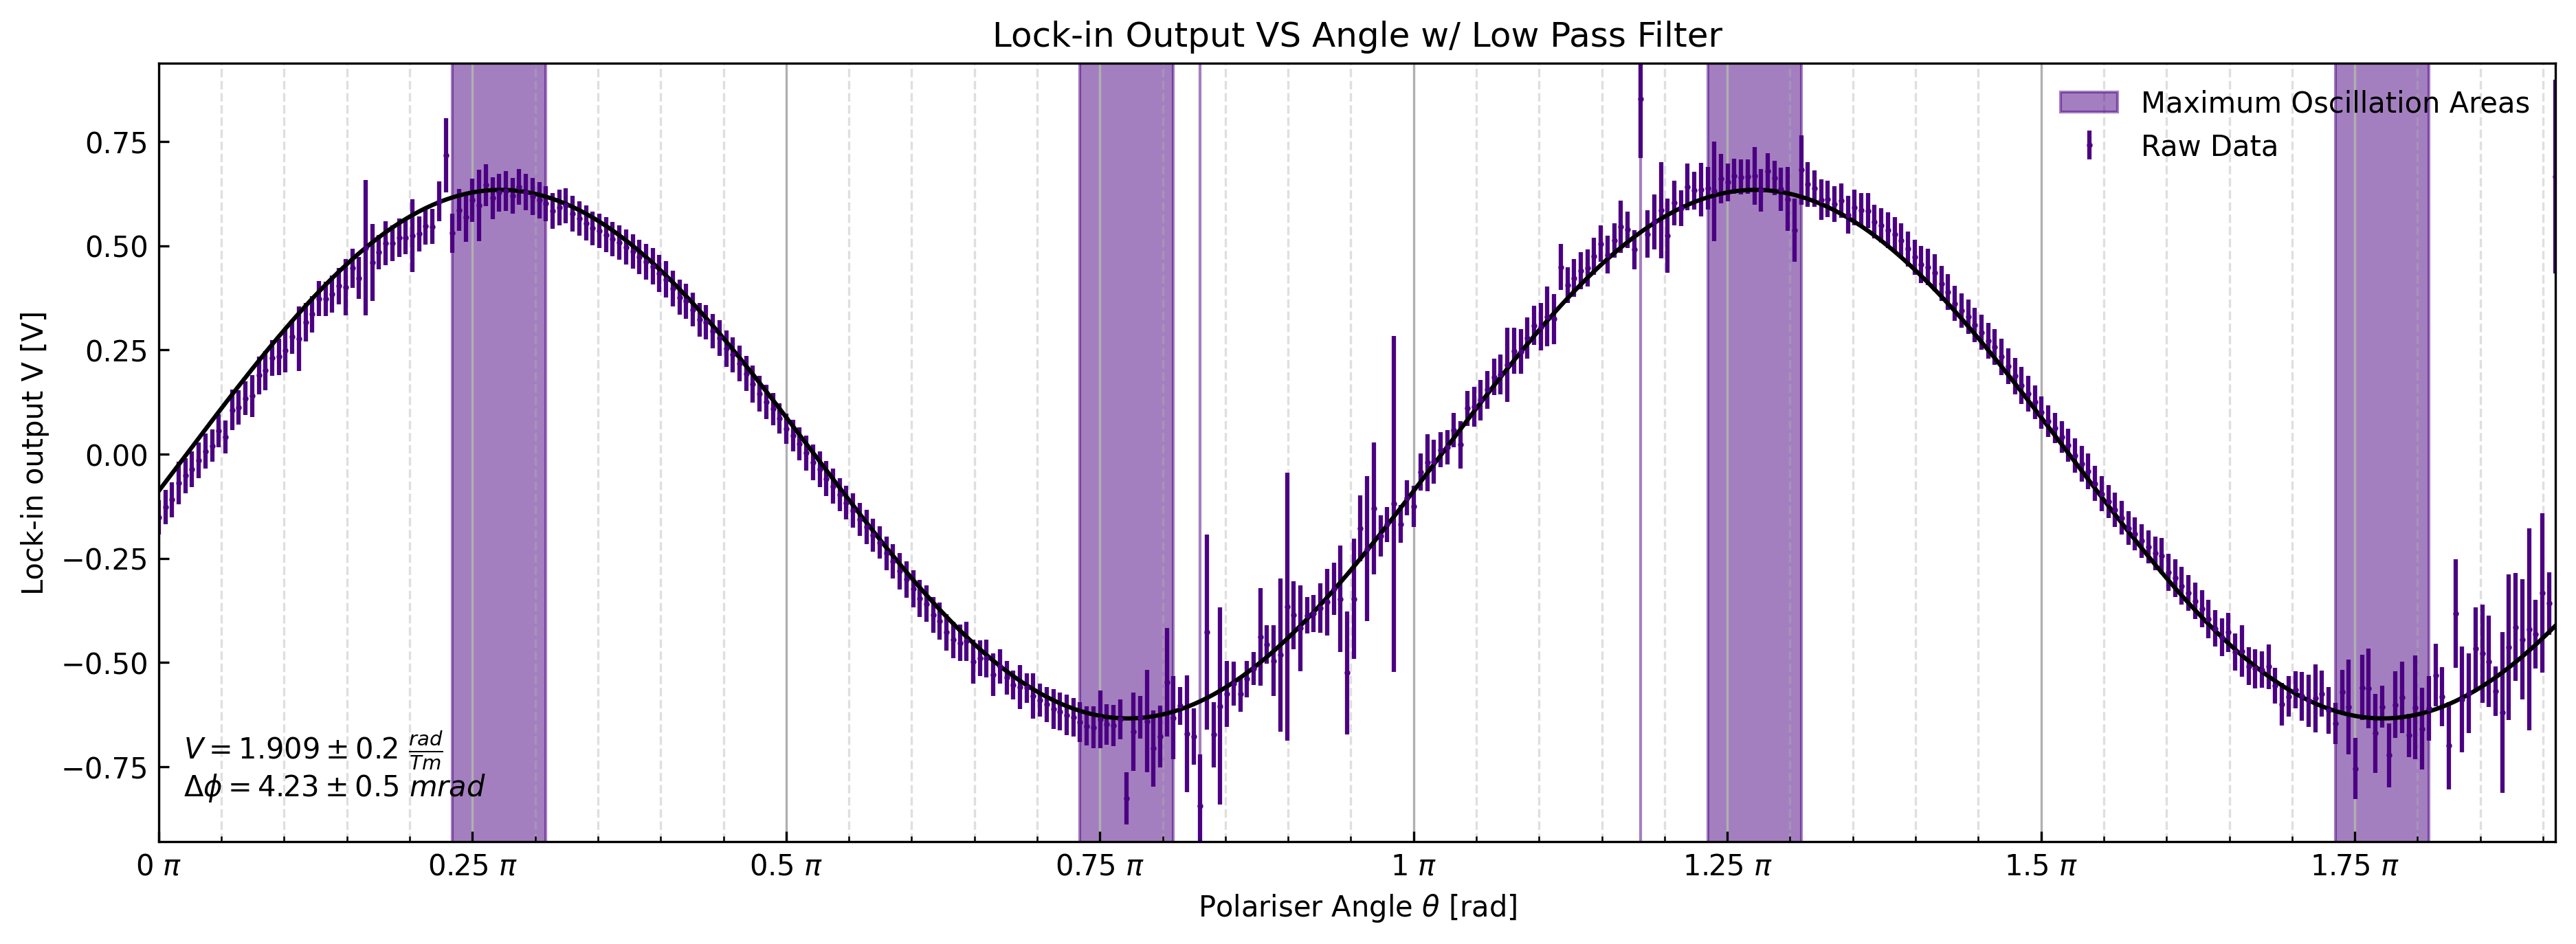

In [173]:
# Set the directory with the measurements
directory = 'AC_VERDET_WATER_LPF'

# Set the parameters of the experiment
params = {
    'P_max'        : 0.5e-3,         # Laser source power in W
    'R_sensor'     : 1e+3,           # Sensor Resistance in Ω
    'K_sensor'     : 0.6,            # Sensor Responsivity in A/W
    'G_preamp'     : 10,             # Preamplifier Gain
    'G_filter'     : 1,              # Low Pass filter Gain
    'G_lock_in'    : 20,             # Lock in Gain
    'K_lock_in'    : 1/10,           # Lock in Constant
    'G_lp_amp'     : 50,             # Lock in, low pass amplifier gain
    'K_solenoid'   : 0.011,          # Solenoid constant in T/A
    'Length'       : 21.2e-2,        # Material length in the solenoid in m
    'Sigma_L'      : 0.05e-2,        # Uncertainty in Length in m
    'Correction'   : pol_angle       # Correction angle to account for the difference of the polarizers
}
angles = np.linspace(0,360,360,dtype=int)
avg = 0.97

# Get the relevant data
voltage, voltage_std, angles = voltage_vs_angle(directory=directory)
angles = np.linspace(0,angle_correction,360)
# voltage -= np.mean(voltage[int(0*angle_correction/360):int(180*angle_correction/360)])
current, current_std, time = get_current_ac(angles=angles,directory=directory)

print_setup(directory)          # Print the setup for the particular experiment

# Fit the data
N = 50
fit_angles = np.zeros(len(angles)*N)
for n in range(N):
    for i in range(len(angles)):
        fit_angles[n*len(angles)+i] = angles[i]/180*np.pi + 2*np.pi*n

fit_voltage = np.tile(voltage,N)

fit = lambda theta, a,b,c,d: a*np.sin(b*theta + c) + d

pars, pcov = curve_fit(fit,fit_angles,fit_voltage,p0=[2,2,-pol_angle_rad,0],)

errors = [(pcov[i][i])**0.5 for i in range(len(pars))]
print(pars)
voltage-=pars[-1]

# Plot the voltage VS angle curve
fig,ax = plot_VA(angles=angles,V=voltage,V_std=voltage_std,directory=directory,average=avg,\
                 title='Lock-in Output VS Angle w/ Low Pass Filter')

ax.plot(angles/180, fit(angles/180*np.pi,*pars)-pars[-1],c='k')

# Calculate Verdet constant
V,V_std, Phi,Phi_std = calc_verdet_ac_given(pars[0],100*errors[0],current,current_std,average=avg,params=params)

ax.text(0.02, -0.73, r'$V=%.3f \pm %.1f\ \frac{rad}{Tm}$'%(V,V_std))
ax.text(0.02, -0.82, r'$\Delta\phi=%.2f \pm %.1f\ mrad}$'%(Phi*1e3,Phi_std*1e3))

F = fit(angles/180*np.pi,*pars)-pars[-1]
ax.fill_between(angles/180, 2*min(F), 2*max(F), where=(abs(F) > max(F)*average), color='indigo',alpha=0.5,\
                    label='Maximum Oscillation Areas')


print("V:\t",V,V_std) # 21.0 rad/Tm
print("φ:\t",Phi,Phi_std)